In [1]:
import numpy as np
import pandas as pd
import scipy
import math

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_validate, learning_curve, StratifiedKFold

import matplotlib.pyplot as plt
import random



from collections import Counter

In [2]:
def plot_curve(plt1, title, xscale, ylim, train_sizes, train_scores, test_scores, xlabel):
    plt1.title.set_text(title)
    if ylim is not None:
        plt1.set_ylim(*ylim)
    plt1.set_xlabel(xlabel + ". Шкала: " + xscale)
    plt1.set_xscale(xscale)
    plt1.set_ylabel("Оценка ROC-AUC")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt1.grid()

    plt1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt1.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Оценка обучения")
    plt1.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Оценка теста")

    plt1.legend(loc="best")
    return

def plot_learning_curve(estimator, title, X, y, ylim, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(12, 6))

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
        scoring='roc_auc'
    )

    plot_curve(plt1, title, 'log', ylim,  train_sizes, train_scores, test_scores, 'Размер данных')  
    plot_curve(plt2, title, 'linear', ylim,  train_sizes, train_scores, test_scores, 'Размер данных')   

    return 

# Peer-graded Assignment: Эксперименты с моделью

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решения.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. 

Задание будет оцениваться на основании загруженного jupyther notebook и развернутых ответов на поставленные вопросы.

## Инструкции

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

In [3]:
df_data = pd.read_csv('orange_small_churn_data.train')
df_labels = pd.read_csv('orange_small_churn_labels.train', names=['Label'], header=None)
df_data['Label'] = df_labels.Label
df_data.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,Label
0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,NaN,...,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN,-1
1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,NaN,...,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN,-1
2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,NaN,-1
3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,NaN,...,e4lqvY0,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN,1
4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,NaN,...,MAz3HNj,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,-1


In [4]:
# df_data = pd.read_csv('not_hold_out_dataset.csv')
# Удалим переменные в которых все значения NaN.
df_tmp = df_data.dropna(axis=1, how='all')
# Преобразование в лоб всех столбцов по OneHotEncoder без предварительной подготовки
# данных приводит к не подъёмному DataFrame. Поэтому для baseline решения применяем LabelEncoder.
df_object = df_tmp.copy()
columns = df_object.select_dtypes(['object']).columns
df_object[columns] = df_object[columns].astype('category')
df_object[columns] = df_object[columns].apply(lambda x: x.cat.codes)

X = df_object.iloc[:,:-1]
# Массив с метками.
y = df_object.iloc[:,-1]

In [9]:
df_object.shape[0] /(2 * df_object['Label'].value_counts())


-1    0.540135
 1    6.728972
Name: Label, dtype: float64

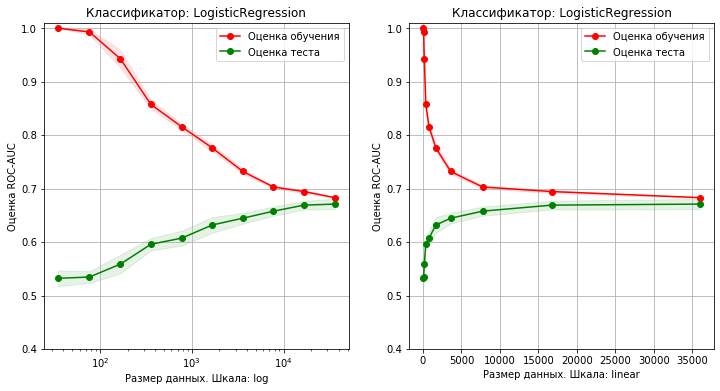

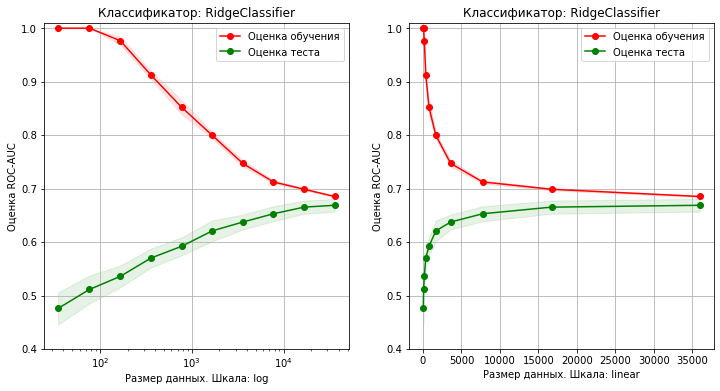

In [5]:
# est = LogisticRegression(solver='liblinear')
# est = RidgeClassifier()
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
# for est in [SGDClassifier(), LogisticRegression(solver='liblinear'), RidgeClassifier(),
#             RandomForestClassifier(n_estimators=500), GradientBoostingClassifier()]:
cv = StratifiedKFold(n_splits=10, shuffle=True)   
si = SimpleImputer(strategy='mean')
scaler = preprocessing.MinMaxScaler()


for est in [  LogisticRegression(solver='liblinear'), RidgeClassifier() ]:
    pipe = Pipeline([('inputer', si), ('scaler', scaler), ('est', est)])
        
    plot_learning_curve(pipe, 'Классификатор: ' + type(est).__name__, X, y, ylim=(0.4, 1.01), 
                    train_sizes=np.logspace(-3, 0, 10), 
                    cv=cv, n_jobs=5)
# train_sizes, train_scores, test_scores =  learning_curve(est, X, y, 
#                scoring='roc_auc', train_sizes=np.array([0.1, 0.33, 0.55, 0.78, 1. ]), cv=3)

plt.show()

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [56]:
np.logspace(-3, 0.1, 20)[:-1]

array([0.001     , 0.00145599, 0.0021199 , 0.00308655, 0.00449398,
       0.00654319, 0.00952681, 0.01387092, 0.0201959 , 0.02940499,
       0.04281332, 0.0623357 , 0.09076005, 0.13214558, 0.19240242,
       0.28013568, 0.40787428, 0.59386019, 0.8646535 ])

In [6]:
%%time
train_score, test_score = [], []
# train_point = np.linspace(1, 10, 10) 
train_point = np.logspace(-3, 2, 20)[:-1]

cv = StratifiedKFold(n_splits=10, shuffle=True)   
si = SimpleImputer(strategy='mean')
scaler = preprocessing.MinMaxScaler()

for cw in [{-1:1, 1:w} for w in train_point]:
    est = LogisticRegression(solver='liblinear', class_weight=cw) 
    pipe = Pipeline([('inputer', si), ('scaler', scaler), ('est', est)])

    cv_rez = cross_validate(pipe, X, y, cv=cv, 
                          return_train_score=True, 
                          return_estimator=True,
                          verbose=0, n_jobs=10,
                          scoring=('roc_auc'))
    train_score.append(cv_rez['train_score'])
    test_score.append(cv_rez['test_score'])
    print(cv_rez['test_score'].mean().round(4), cv_rez['train_score'].mean().round(4), cw)

0.5569 0.558 {-1: 1, 1: 0.001}
0.5722 0.574 {-1: 1, 1: 0.0018329807108324356}
0.5926 0.5953 {-1: 1, 1: 0.003359818286283781}
0.6153 0.6191 {-1: 1, 1: 0.006158482110660267}
0.6345 0.6393 {-1: 1, 1: 0.011288378916846888}
0.6474 0.6537 {-1: 1, 1: 0.02069138081114789}
0.6567 0.6631 {-1: 1, 1: 0.0379269019073225}
0.6606 0.6693 {-1: 1, 1: 0.06951927961775606}
0.6645 0.6736 {-1: 1, 1: 0.12742749857031335}
0.6672 0.677 {-1: 1, 1: 0.23357214690901212}
0.6686 0.6799 {-1: 1, 1: 0.42813323987193913}
0.6695 0.6823 {-1: 1, 1: 0.7847599703514607}
0.6695 0.6842 {-1: 1, 1: 1.438449888287663}
0.67 0.6857 {-1: 1, 1: 2.636650898730358}
0.6695 0.6868 {-1: 1, 1: 4.832930238571752}
0.6718 0.6873 {-1: 1, 1: 8.858667904100823}
0.6706 0.6875 {-1: 1, 1: 16.23776739188721}
0.6683 0.6872 {-1: 1, 1: 29.763514416313193}
0.6681 0.6862 {-1: 1, 1: 54.555947811685144}
CPU times: user 3.31 s, sys: 1.25 s, total: 4.55 s
Wall time: 3min 31s


In [7]:
est = LogisticRegression(solver='liblinear', class_weight='balanced')
pipe = Pipeline([('inputer', si), ('scaler', scaler), ('est', est)])
cv_rez = cross_validate(pipe, X, y, cv=cv, 
                  return_train_score=True, 
                  return_estimator=True,
                  verbose=0, n_jobs=4,
                  scoring=('roc_auc'))

balanced_test = cv_rez['test_score'].mean()
balanced_train = cv_rez['train_score'].mean()
print(cw, cv_rez['test_score'].mean(), cv_rez['train_score'].mean())


{-1: 1, 1: 54.555947811685144} 0.6702523227755198 0.6866482323596508


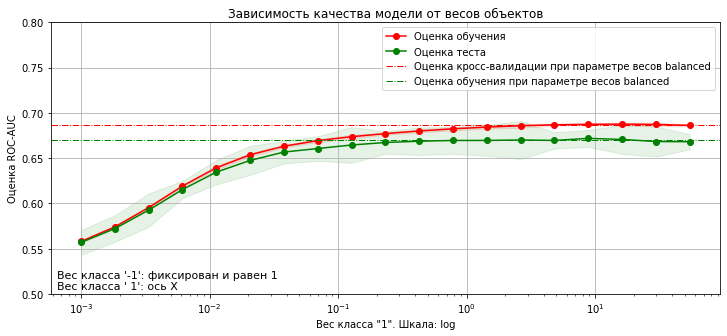

In [9]:
# fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(9, 4))
fig, plt1 = plt.subplots(1, 1, figsize=(12, 5))

plot_curve(plt1, 'Зависимость качества модели от весов объектов', 'log', 
           (0.5, .8),  train_point, train_score, test_score, 'Вес класса "1"') 
plt1.axhline(balanced_train, color='r', lw=1, ls='-.', label='Оценка кросс-валидации при параметре весов balanced') 
plt1.axhline(balanced_test, color='g', lw=1, ls='-.', label='Оценка обучения при параметре весов balanced') 
plt1.legend(loc="best")
plt1.text(0.01, 0.01, "Вес класса '-1': фиксирован и равен 1\nВес класса ' 1': ось X", 
         transform=plt1.transAxes, fontsize=11, verticalalignment='bottom')
plt.show()

In [52]:
 [w if isinstance(w, str) else {1:w, -1:(1.-w)} for w in [0.1, 0.3, 0.5, 'balanced']]

[{1: 0.1, -1: 0.9}, {1: 0.3, -1: 0.7}, {1: 0.5, -1: 0.5}, 'balanced']

In [110]:
df_object.shape[0] /(2 * df_object['Label'].value_counts())

0    0.540135
1    6.728972
Name: Label, dtype: float64

In [25]:
df_object['Label'].value_counts()

 1    2675
-1     118
Name: Label, dtype: int64

2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

https://towardsdatascience.com/sampling-techniques-for-extremely-imbalanced-data-part-ii-over-sampling-d61b43bc4879  
conda install -c conda-forge imbalanced-learn

In [22]:
sampler = RandomUnderSampler(sampling_strategy=.1)
si = SimpleImputer(strategy='mean')
X_rs = si.fit_transform(X)
X_rs, y_rs = sampler.fit_sample(X, y.values)
print('Cluster centriods undersampling {}'.format(Counter(y_rs)))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [21]:
%%time
df_data = pd.read_csv('not_hold_out_dataset.csv')
df_data['CountNotNull'] = df_data.count(axis=1)
min_max_scaler = preprocessing.MinMaxScaler()
columns = df_data.select_dtypes(['object']).columns

cv = StratifiedKFold(n_splits=5, shuffle=True)
train_score, test_score, train_point = [], [], []

for border in [0] + list(range(70, 79)) :
    print(border, df_object.shape)

    df_object = df_data[ ((df_data['Label'] == -1) & (df_data['CountNotNull'] > border)) | 
                        (df_data['Label'] == 1) ].copy()
    df_object[columns] = df_object[columns].astype('category')
    df_object[columns] = df_object[columns].apply(lambda x: x.cat.codes)
    X = df_object.iloc[:,:-2]
    si = SimpleImputer(strategy='mean')
    X = si.fit_transform(X)
    y = df_object.iloc[:,-2]
    print('Start cross_validate')
    est = LogisticRegression(solver='liblinear') 
    cv_rez = cross_validate(est, X, y, cv=cv, 
                          return_train_score=True, 
                          return_estimator=True,
                          verbose=0, n_jobs=4,
                          scoring=('roc_auc'))
    train_score.append(cv_rez['train_score'])
    test_score.append(cv_rez['test_score'])
    train_point.append(df_object.shape[0])
    print(cv_rez['test_score'].mean().round(4), cv_rez['train_score'].mean().round(4), border)


0 (2793, 233)
0 (36000, 233)
Start cross_validate
0.5988 0.6127 0
70 (36000, 233)
70 (26058, 233)
Start cross_validate
0.6533 0.6692 70
71 (26058, 233)
71 (21784, 233)
Start cross_validate
0.6553 0.6657 71
72 (21784, 233)
72 (18015, 233)
Start cross_validate
0.7019 0.7142 72
73 (18015, 233)
73 (15948, 233)
Start cross_validate
0.7193 0.7268 73
74 (15948, 233)
74 (13242, 233)
Start cross_validate
0.7093 0.7253 74
75 (13242, 233)
75 (9475, 233)
Start cross_validate
0.7525 0.7703 75
76 (9475, 233)
76 (6315, 233)
Start cross_validate
0.7324 0.7537 76
77 (6315, 233)
77 (4001, 233)
Start cross_validate
0.754 0.7728 77
78 (4001, 233)
78 (2793, 233)
Start cross_validate
0.7149 0.7965 78
Wall time: 9min 38s


In [16]:
# [26058, 21784, 18015, 15948, 13242, 9475, 6315, 4001, 2793]
[36000 - x for x in train_point]

[0, 9942, 14216, 17985, 20052, 22758, 26525, 29685, 31999, 33207]

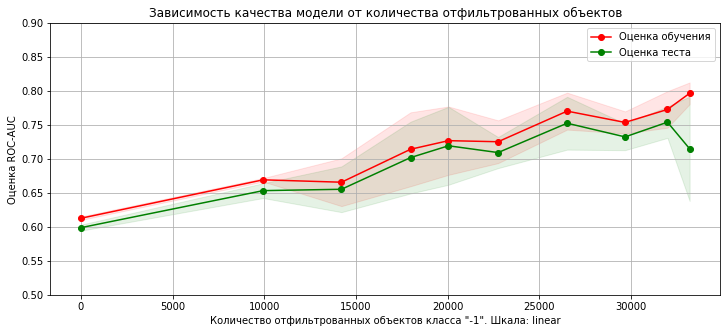

In [23]:
fig, plt1 = plt.subplots(1, 1, figsize=(12, 5))
# train_point = [26058, 21784, 18015, 15948, 13242, 9475, 6315, 4001, 2793] 
# range(70, 79)

plot_curve(plt1, 'Зависимость качества модели от количества отфильтрованных объектов', 'linear', 
           (0.5, .9),  [df_data.shape[0] - x for x in train_point], 
           train_score, test_score, 'Количество отфильтрованных объектов класса "-1"') 
plt.show()

In [12]:
train_point = [0] + list(range(70, 79)) 
train_point

[0, 70, 71, 72, 73, 74, 75, 76, 77, 78]

In [107]:
df_data[['CountNotNull', 'Label']].groupby(['CountNotNull']).agg([ 'count'])

,Label
,count
CountNotNull,
49,1
51,1
52,14
53,66
54,76
55,163
56,154
57,77


In [57]:
# np.linspace(0, df.loc[-1] - df.loc[1], 10, dtype=int)
df

-1    33325
 1     2675
Name: Label, dtype: int64

In [13]:
%%time
# Второй тип отбора строк для удаления - случайный
# df_data = pd.read_csv('not_hold_out_dataset.csv')

# columns = df_data.select_dtypes(['object']).columns
cv = StratifiedKFold(n_splits=10, shuffle=True)   
si = SimpleImputer(strategy='mean')
scaler = preprocessing.MinMaxScaler()
est = LogisticRegression(solver='liblinear') 

pipe = Pipeline([('inputer', si), ('scaler', scaler), ('est', est)])



train_score, test_score = [], []

df = df_data['Label'].value_counts()
train_point = np.linspace(0, df.loc[-1] - df.loc[1], 20, dtype=int)

l_index = list(df_data[df_data['Label'] == -1].index)

for border in train_point:
    df_object = df_data.drop( random.sample(l_index,  border) ).copy()
    print(border, df_object.shape[0])
    df_object[columns] = df_object[columns].astype('category')
    df_object[columns] = df_object[columns].apply(lambda x: x.cat.codes)
    
    X = df_object.iloc[:,:-1]
    y = df_object.iloc[:,-1]
    
    cv_rez = cross_validate(pipe, X, y, cv=cv, 
                          return_train_score=True, 
                          return_estimator=True,
                          verbose=0, n_jobs=10,
                          scoring=('roc_auc'))
    train_score.append(cv_rez['train_score'])
    test_score.append(cv_rez['test_score'])
    print(cv_rez['test_score'].mean().round(4), cv_rez['train_score'].mean().round(4), border)


0 40000
0.6699 0.6831 0
1792 38208
0.6697 0.6837 1792
3584 36416
0.6711 0.6833 3584
5376 34624
0.6695 0.6832 5376
7168 32832
0.6691 0.6826 7168
8960 31040
0.6683 0.6826 8960
10752 29248
0.6686 0.6835 10752
12544 27456
0.6725 0.685 12544
14336 25664
0.6712 0.6846 14336
16128 23872
0.6688 0.6839 16128
17920 22080
0.6693 0.6853 17920
19712 20288
0.6726 0.6876 19712
21504 18496
0.6694 0.6853 21504
23296 16704
0.6705 0.687 23296
25088 14912
0.6706 0.688 25088
26880 13120
0.6665 0.6852 26880
28672 11328
0.6756 0.693 28672
30464 9536
0.668 0.6891 30464
32256 7744
0.6666 0.691 32256
34048 5952
0.6711 0.7 34048
CPU times: user 32.9 s, sys: 3.7 s, total: 36.6 s
Wall time: 2min 34s


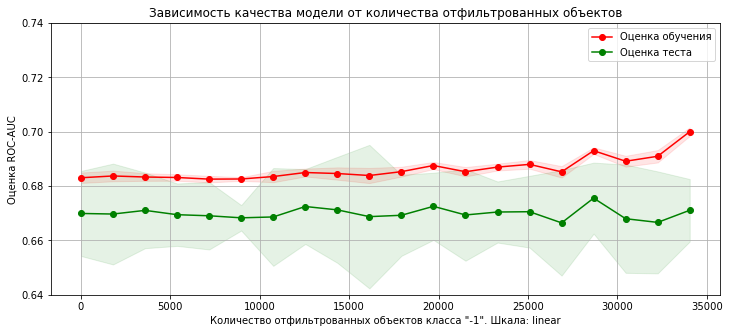

In [16]:
fig, plt1 = plt.subplots(1, 1, figsize=(12, 5))
plot_curve(plt1, 'Зависимость качества модели от количества отфильтрованных объектов', 'linear', 
           (0.64, .74),   train_point, 
           train_score, test_score, 'Количество отфильтрованных объектов класса "-1"') 
plt.show()

In [107]:
# df_data = pd.read_csv('not_hold_out_dataset.csv', index_col=0)
df_data.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,Label,CountNotNull
0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,NaN,...,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN,-1,62
1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,NaN,...,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN,-1,75
2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,NaN,...,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,NaN,-1,71
3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,NaN,...,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN,1,67
4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,NaN,...,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,-1,70


In [43]:
%%time
# Отбор с применением библиотеки 
df_data = pd.read_csv('orange_small_churn_train_data.csv',  index_col=0)

# columns = df_data.select_dtypes(['object']).columns
cv = StratifiedKFold(n_splits=10, shuffle=True)   
si = SimpleImputer(strategy='mean')
scaler = preprocessing.MinMaxScaler()
est = LogisticRegression(solver='liblinear') 

train_score, test_score = [], []

columns = df_data.select_dtypes(['object']).columns
df_data[columns] = df_data[columns].astype('category')
df_data[columns] = df_data[columns].apply(lambda x: x.cat.codes)
X = si.fit_transform(df_object.iloc[:,:-1])
y = df_object.iloc[:,-1]


for sampling_strategy in [1]: #np.linspace(0.2, 1, 5) :
#     sampler = RandomUnderSampler(sampling_strategy=sampling_strategy)
    sampler = TomekLinks() # sampling_strategy=sampling_strategy)
    X_rs, y_rs = sampler.fit_sample(X, y)

    pipe = Pipeline([('scaler', scaler), ('est', est)])
    cv_rez = cross_validate(pipe, X_rs, y_rs, cv=cv, 
                          return_train_score=True, 
                          return_estimator=True,
                          verbose=0, n_jobs=10,
                          scoring=('roc_auc'))
    train_score.append(cv_rez['train_score'])
    test_score.append(cv_rez['test_score'])
    print(cv_rez['test_score'].mean().round(4), cv_rez['train_score'].mean().round(4), sampling_strategy)


0.6724 0.6847 1
CPU times: user 1min 56s, sys: 1.91 s, total: 1min 58s
Wall time: 2min 7s


In [42]:
print('Cluster centriods undersampling {}'.format(Counter(y_rs)))

Cluster centriods undersampling Counter({-1: 35764, 1: 2976})


In [ ]:
pd.read_csv

3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [105]:
%%time
df_data = pd.read_csv('not_hold_out_dataset.csv', index_col=0)
df_data['CountNotNull'] = df_data.count(axis=1)
df_object = df_data.drop( df_data[(df_data['Label'] == -1) & (df_data['CountNotNull'] < 78 ) ].index)

columns = df_data.select_dtypes(['object']).columns
df_object[columns] = df_object[columns].astype('category')
df_object[columns] = df_object[columns].apply(lambda x: x.cat.codes)

cv = StratifiedKFold(n_splits=10, shuffle=True)
train_score3, test_score3 = [], []


train_point3 = ['mean', 'median', 'most_frequent', 'constant']
fill_values = [None, None, None, -10000000]

# min(df_object.iloc[:,:-2].min())                         
                         
for (strategy, fill_value) in zip(train_point3, fill_values):
#     print(strategy, fill_value)
    si = SimpleImputer(strategy=strategy, fill_value=fill_value)
    X = df_object.iloc[:,:-2]
    y = df_object.iloc[:,-2]
    est = LogisticRegression(solver='liblinear') 
    pipe = Pipeline([('inputer', si), ('est', est)])
    
    cv_rez = cross_validate(pipe, X, y, cv=cv, 
                          return_train_score=True, 
                          return_estimator=True,
                          verbose=0, n_jobs=4,
                          scoring=('roc_auc'))
    train_score3.append(cv_rez['train_score'])
    test_score3.append(cv_rez['test_score'])
    print(cv_rez['test_score'].mean().round(4), cv_rez['train_score'].mean().round(4), strategy)


0.7261 0.7852 mean
0.8421 0.8725 median
0.917 0.9408 most_frequent
0.9949 0.9978 constant
Wall time: 1min


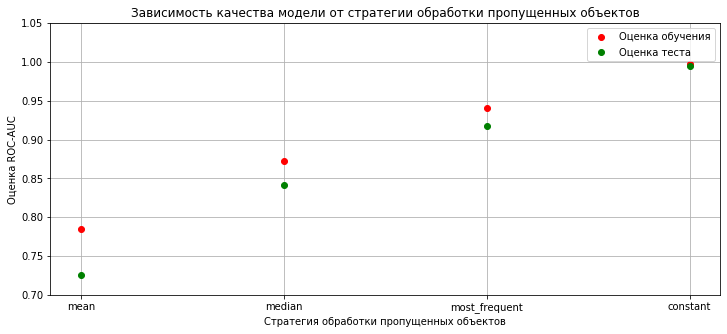

In [106]:
fig, plt1 = plt.subplots(1, 1, figsize=(12, 5))
# plot_curve(plt1, 'Зависимость качества модели от стратегии обработки пропущенных объектов', 'linear', 
#            (0.7, .95),   train_point3, 
#            train_score3, test_score3, 'Cтратегия обработки пропущенных объектов') 
plt1.title.set_text('Зависимость качества модели от стратегии обработки пропущенных объектов')
plt1.set_ylim((0.7, 1.05))
plt1.set_xlabel('Cтратегия обработки пропущенных объектов')
# plt1.set_xscale(xscale)
plt1.set_ylabel("Оценка ROC-AUC")

plt1.grid()

plt1.plot(train_point3, np.mean(train_score3, axis=1) , 'o', color="r", 
         label="Оценка обучения")
plt1.plot(train_point3, np.mean(test_score3, axis=1), 'o', color="g",
         label="Оценка теста")

plt1.legend(loc="best")


plt.show()

In [101]:
df_test.head()

,Id,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,0,NaN,NaN,NaN,NaN,NaN,1225.0,7.0,NaN,NaN,...,6,302,3,-1,0,22,1,18,-1,NaN
1,1,NaN,NaN,NaN,NaN,NaN,896.0,14.0,NaN,NaN,...,4,577,0,-1,-1,22,2,8,-1,NaN
2,2,NaN,NaN,NaN,NaN,NaN,791.0,7.0,NaN,NaN,...,4,173,0,-1,1,17,2,8,1,NaN
3,3,NaN,NaN,NaN,NaN,NaN,2296.0,7.0,NaN,NaN,...,4,149,3,-1,1,17,2,8,0,NaN
4,4,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,...,4,694,0,-1,-1,4,2,8,-1,NaN


In [108]:
df_test = pd.read_csv('orange_small_churn_test_data.csv', index_col=0)
df_test.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
ID,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,1225.0,7.0,NaN,NaN,NaN,...,zCkv,APgdzOv,jySVZNlOJy,NaN,ELof,xb3V,6fzt,Zy3gnGM,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,896.0,14.0,NaN,NaN,NaN,...,oslk,IIvC99a,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,791.0,7.0,NaN,NaN,NaN,...,oslk,6YSocsg,LM8l689qOp,NaN,kG3k,rgKb,RAYp,F2FyR07IdsN7I,mj86,NaN
3,NaN,NaN,NaN,NaN,NaN,2296.0,7.0,NaN,NaN,NaN,...,oslk,5nQ7A2G,jySVZNlOJy,NaN,kG3k,rgKb,RAYp,F2FyR07IdsN7I,am7c,NaN
4,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,NaN,...,oslk,MI8s5nE,LM8l689qOp,NaN,NaN,7P5s,RAYp,F2FyR07IdsN7I,NaN,NaN


In [110]:
df_test = pd.read_csv('orange_small_churn_test_data.csv', index_col=0)

columns = df_test.select_dtypes(['object']).columns
df_test[columns] = df_test[columns].astype('category')
df_test[columns] = df_test[columns].apply(lambda x: x.cat.codes)

est = LogisticRegression(solver='liblinear') 
si = SimpleImputer(strategy='median', fill_value =-10000000 )
X = df_object.iloc[:,:-2]
y = df_object.iloc[:,-2]

pipe = Pipeline([('inputer', si), ('est', est)])
pipe.fit(X, y)
y_test = pipe.predict_proba(df_test)
df_test['result'] = y_test[:,1]
df_test[[ 'result']].round(2).to_csv('dminik6_part2_w3_04.csv', index=True)

C:\ProgramData\Anaconda2\envs\newpy\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [2]:
def cross_validate_rezult(cv_rez):
    return [
#         type(cv_rez['estimator'][0]).__name__, 
        type(cv_rez['estimator'][0][2]).__name__,
        cv_rez['train_score'].mean(),
        cv_rez['test_score'].mean(),
        len(cv_rez['estimator']),
        cv_rez['fit_time'].mean()            
    ]

In [3]:
df_data = pd.read_csv('not_hold_out_dataset.csv', index_col=0)
cat_var = df_data.select_dtypes(['object']).columns
cat_num = df_data.select_dtypes(exclude=['object']).columns[:-1]

In [4]:
df_data[cat_num].head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var183,Var184,Var185,Var186,Var187,Var188,Var189,Var190,Var209,Var230
0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,276.0,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# %%time
# df_cat_var = df_data[cat_var].copy()
# # Блок позволяет подобрать порог отсечения мелких категорий (проценты от max к)
# # исходя из желаемого количества столбцов
# n_columns = 0.
# threshold = 150
# for col in cat_var:
#     val_count = df_cat_var[col].value_counts()
#     new_cols = val_count.shape[0]
#     if new_cols > threshold:
#          #val_count.max() * 0.01
#         to_remove = val_count.drop(val_count.head(threshold).index).index
#         new_cols = new_cols - len(to_remove) + 1
#         print('{} {:>6.0f} {:>6.0f}'.format(col, val_count.shape[0], new_cols ))
        
#         df_cat_var[col].replace(to_remove, 'other', inplace=True)
    
#     n_columns += new_cols 
# # val_count.shape[0]
# print('Columns:', n_columns)

In [6]:
# df_cat_var_dummies = pd.get_dummies(df_cat_var)
# df_cat_var_dummies.info()

In [7]:
def CalcCorr(Y, X):
    iY0 = np.nonzero(Y==-1)
    iY1 = np.nonzero(Y==1)
    iX0 = np.nonzero(X==0)
    iX1 = np.nonzero(X==1)
#     print(iY0, iY1, iX0, iX1)
    a = 1.*len(np.intersect1d(iY0, iX0))
    b = 1.*len(np.intersect1d(iY0, iX1))
    c = 1.*len(np.intersect1d(iY1, iX0))
    d = 1.*len(np.intersect1d(iY1, iX1))
#     print(a, b, c, d)
    return (a*d-b*c)/(math.sqrt((a+b)*(c+d)*(a+c)*(b+d) ))

# Y = np.array([-1, -1, -1, 1, 1, 1, 1], dtype='int8')
# X = np.array([ 0,  0,  0, 0, 1, 0, 0], dtype='int8')
# CalcCorr(Y, X)   
# np.nonzero(Y==-1)

In [8]:
# df_data[cat_var[1]].value_counts().to_dict()
# ser.to_dict()
# where(ser > 10)
# d = np.array(pd.get_dummies(df_data['Var210']).values)
# d[:,1].shape

In [6]:
%%time
# Методика отбора признаков - по наибольшей корреляции

# Вычисление корреляции каждой переменной в каждом категориальном параметре
# Цель - в дальнейшем оставить переменные и значения с наибольшей корреляцией
# или коррелирующиеся.
# Так как расчет выполняется несколько минут (только что - 7 минут, с введением фильтра 
# по количеству переменных равных 50 - 12 сек.),
# то данные сохранены в файл
acorr = []
aLabels = np.array(df_data['Label'].values)
for c in cat_var:
    
    dVals = df_data[c].value_counts().to_dict()
    df_dummies=pd.get_dummies(df_data[c])
    print(c, len(dVals), end=' ')
    d = np.array(df_dummies.values)
    for i, c_val in enumerate(df_dummies.columns):
#         if dVals[c_val] > 50:
        rez = CalcCorr(aLabels, d[:,i])
#             rez = CalcCorr(aLabels, np.array(df_dummies[c_val].values))
        acorr.append([c, c_val, dVals[c_val], rez])

            # df_data['Var193']
df_corr_categ = pd.DataFrame(acorr, columns=['Var', 'Val', 'Count', 'correlation'], index=None)
df_corr_categ.to_pickle('df_corr_categ.bin')

Var191 1 Var192 352 Var193 49 Var194 3 Var195 23 Var196 4 Var197 216 Var198 3730 Var199 4115 Var200 12334 Var201 2 Var202 5451 Var203 5 Var204 100 Var205 3 Var206 21 Var207 14 Var208 2 Var210 6 Var211 2 Var212 78 Var213 1 Var214 12334 Var215 1 Var216 1739 Var217 11784 Var218 2 Var219 22 Var220 3730 Var221 7 Var222 3730 Var223 4 Var224 1 Var225 3 Var226 23 Var227 7 Var228 29 Var229 4 CPU times: user 9min 35s, sys: 12.7 s, total: 9min 48s
Wall time: 9min 28s


In [9]:
df_corr_categ = pd.read_pickle('df_corr_categ.bin')
df_corr_categ['correlation_abs'] = df_corr_categ['correlation'].abs()

In [10]:
df = df_corr_categ.sort_values(by=['correlation_abs'], ascending =False)
df = df[(df['Count'] > 0) & (df['correlation_abs'] > 0.0187)]
# При df[df['correlation_abs'] > 0.0188] плучено значение  roc-auc = 0.7491
# с классификатором GradientBoostingClassifier
# df = df[df['correlation_abs'] > 0.018]
df.shape

(228, 5)

In [11]:
%%time
df_cat_var = df_data[df['Var'].unique()].copy()
for col in df_cat_var.columns:
    val_set = set(df[ df['Var'] == col]['Val'].values)
    df_cat_var[col] = df_cat_var[col].apply(lambda x: x if x in val_set else 'other')

CPU times: user 413 ms, sys: 479 µs, total: 413 ms
Wall time: 410 ms


In [12]:
df_cat_var['Var212'].value_counts()
# df_data['Var202'].value_counts()

NhsEn4L          21025
other             6940
XfqtO3UdzaXh_     4631
CrNX              2180
4kVnq_T26xq1p      712
_5OXC8MSLt         512
Name: Var212, dtype: int64

In [13]:
df_cat_var_dummies = pd.get_dummies(df_cat_var)
# df_cat_var_dummies.info()

In [14]:
df_test = pd.concat([df_data[cat_num], df_cat_var_dummies ], axis=1)
X = df_test.values
# Массив с метками.
y = df_data['Label'].values
df_test = None

In [15]:
# X, y = None, None

In [16]:
X.shape

(36000, 444)

In [17]:
# df_cat_var_dummies = None
# df_cat_var = None
# df_data = None

In [19]:
%%time
train_score, test_score = [], []

cv = StratifiedKFold(n_splits=10, shuffle=True)   
si = SimpleImputer(strategy='median')
# 'median', 'most_frequent' mean
scaler = preprocessing.MinMaxScaler()
# scaler = preprocessing.StandardScaler()
rez = []
for est in [
    SGDClassifier(), 
    LinearSVC(),
    LogisticRegression( solver='lbfgs' ),
    RidgeClassifier(),
    RandomForestClassifier(), 
#     SVC(kernel='linear'),
    GradientBoostingClassifier()
]:
    pipe = Pipeline([
        ('inputer', si), 
        ('scaler', scaler), 
        ('est', est)
    ])
    print(type(est).__name__, end=' ')
    cv_rez = cross_validate(pipe, X, y, cv=cv, 
                          return_train_score=True, 
                          return_estimator=True,
    
                            verbose=0, n_jobs=4,
                          scoring=('roc_auc'))
    print(cv_rez['test_score'].mean().round(4))
    rez.append(cross_validate_rezult(cv_rez))
#     train_score.append(cv_rez['train_score'])
#     test_score.append(cv_rez['test_score'])
#     print(cv_rez['test_score'].mean().round(4), cv_rez['train_score'].mean().round(4), type(est).__name__)

SGDClassifier 0.6709
LinearSVC 0.7148
LogisticRegression 0.7178
RidgeClassifier 0.7148
RandomForestClassifier 0.6313
GradientBoostingClassifier 0.75
CPU times: user 1.08 s, sys: 1.19 s, total: 2.27 s
Wall time: 6min 19s


In [20]:
rez_df = pd.DataFrame(rez, columns=['Алгоритм классификации', 
                                   'ROC-AUC train', 'ROC-AUC test', 
                                   'Количество фолдов', 'Время обучения фолда'])
rez_df = rez_df.round(decimals=4).sort_values(by=['ROC-AUC test'])
rez_df

,Алгоритм классификации,ROC-AUC train,ROC-AUC test,Количество фолдов,Время обучения фолда
4,RandomForestClassifier,0.9998,0.6313,10,8.5234
0,SGDClassifier,0.6760,0.6709,10,8.7688
1,LinearSVC,0.7337,0.7148,10,38.2171
3,RidgeClassifier,0.7312,0.7148,10,6.7250
2,LogisticRegression,0.7304,0.7178,10,10.2986
5,GradientBoostingClassifier,0.7804,0.7500,10,46.9599


## threshold = 30

0.6801 0.738 LogisticRegression  
0.6736 0.7365 RidgeClassifier

Без preprocessing.MinMaxScaler()  
0.5962 0.6077 LogisticRegression  
0.6726 0.7372 RidgeClassifier  
Wall time: 7min 22s


scaler = preprocessing.StandardScaler()  
0.6685 0.7465 LogisticRegression  
0.6697 0.7376 RidgeClassifier  
Wall time: 10min 41s


si = SimpleImputer(strategy='median')  
0.6791 0.7391 RidgeClassifier  
Wall time: 5min 18s


si = SimpleImputer(strategy='median')  
0.6833 0.7411 LogisticRegression  
Wall time: 5min


## threshold = 50
si = SimpleImputer(strategy='median')  
0.684 0.7549 LogisticRegression  
0.6798 0.7537 RidgeClassifier  
Wall time: 17min 5s  



5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 